In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import tensorflow as tf
import gzip
from PIL import Image
import io
import numpy as np
import pickle

In [ ]:
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import tensorflow as tf
import pickle
import numpy as np
from tqdm import tqdm
import re

class FireDataset(Dataset):
    def __init__(self, dataframe, features_path, bucket, folder):
        self.dataframe = dataframe
        self.bucket = bucket
        self.folder = folder
        self.features_dict = self._load_features(features_path)
        self.preloaded_images = {}
        self.available_indices = []  # To track indices with available images

        self._preload_images()
        self._filter_dataframe()
        self.feature_names = self.dataframe.iloc[0].drop(['export_index', 'report_id', 'id', 'next_area_diff', 'day_since_first_report']).index.tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        features = torch.tensor(row.drop(['export_index', 'report_id', 'id', 'next_area_diff', 'day_since_first_report']).values.astype(float), dtype=torch.float)
        target = torch.tensor(row['next_area_diff'], dtype=torch.float)
        images_key = (row['id'], int(row['day_since_first_report']))
        images_tensor = self.preloaded_images.get(images_key, torch.zeros(7, 64, 64, dtype=torch.float))
        return features, images_tensor, target

    def _load_features(self, features_path):
        with open(features_path, "rb") as f:
            return pickle.load(f)

    def _preload_images(self):
        for index, row in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            fire_id = row['id']
            day_since_first_report = row['day_since_first_report']
            cleaned_fire_id = self._clean_fire_id(fire_id)
            tfrecord_path = self._get_tfrecord_path(cleaned_fire_id)

            cleaned_fire_id2 = self._clean_fire_id2(fire_id)
            tfrecord_path2 = self._get_tfrecord_path(cleaned_fire_id2)

            try:
                self.preloaded_images[(fire_id, int(day_since_first_report))] = self._load_and_parse_tfrecord(tfrecord_path, day_since_first_report)
            except FileNotFoundError:
              try:
                self.preloaded_images[(fire_id, int(day_since_first_report))] = self._load_and_parse_tfrecord(tfrecord_path2, day_since_first_report)
              except:
                print(f"TFRecord not found: {tfrecord_path}\n{tfrecord_path2}")

    def _clean_fire_id(self, fire_id):
        pattern = r'[^a-zA-Z0-9.,:_;-]'
        return re.sub(pattern, '', fire_id)

    def _clean_fire_id2(self, fire_id):
        pattern = r'[^a-zA-Z0-9.,:_; -]'
        return re.sub(pattern, '', fire_id)

    def _get_tfrecord_path(self, cleaned_fire_id):
        return f"gs://{self.bucket}/{self.folder}/{cleaned_fire_id}.tfrecord.gz"

    def _get_tfrecord_path(self, cleaned_fire_id):
        return f"gs://{self.bucket}/{self.folder}/{cleaned_fire_id}.tfrecord.gz"

    def _load_and_parse_tfrecord(self, tfrecord_path, day_since_first_report):
        layers = ['pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs', 'erc']
        day = f"{int(day_since_first_report):02}"
        images_array = np.zeros((7, 64, 64))

        raw_dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type='GZIP')
        for raw_record in raw_dataset.take(1):
            example = tf.io.parse_single_example(raw_record, self.features_dict)
            for i, layer in enumerate(layers):
                key = f'{day}_{layer}'
                if key in example:
                    images_array[i] = example[key].numpy()
                else:
                    raise FileNotFoundError(f"Key {key} not found in TFRecord.")

        return torch.tensor(images_array, dtype=torch.float)
dataset = torch.load("/content/drive/My Drive/RA/cleaned_dataset.pt")

In [ ]:
features = dataset.dataframe.iloc[0].drop(['export_index', 'report_id', 'id', 'next_area_diff', 'day_since_first_report']).index.tolist()
feature2id = {f:i for i, f in enumerate(features)}
id2feature = {i:f for i, f in enumerate(features)}

Report index: 10507, fire id: 2016_4452309_CHIMNEY TOPS 2


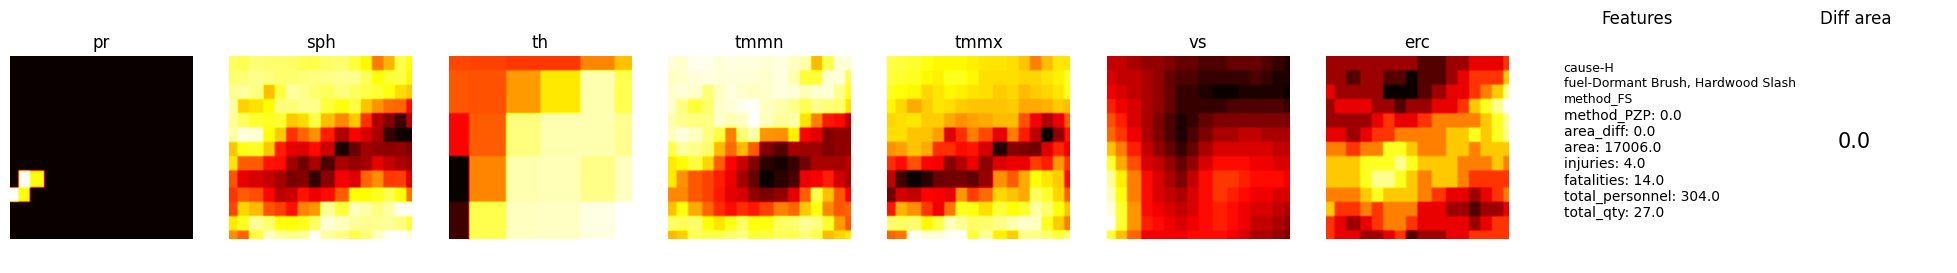

Report index: 21952, fire id: 2018_9185615_BEARS


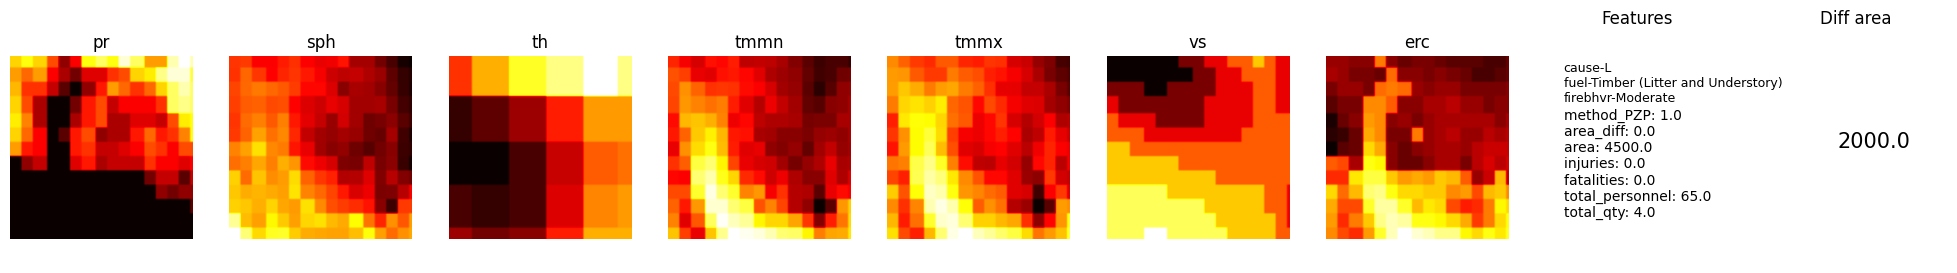

Report index: 5253, fire id: 2016_4253862_STATE LINE


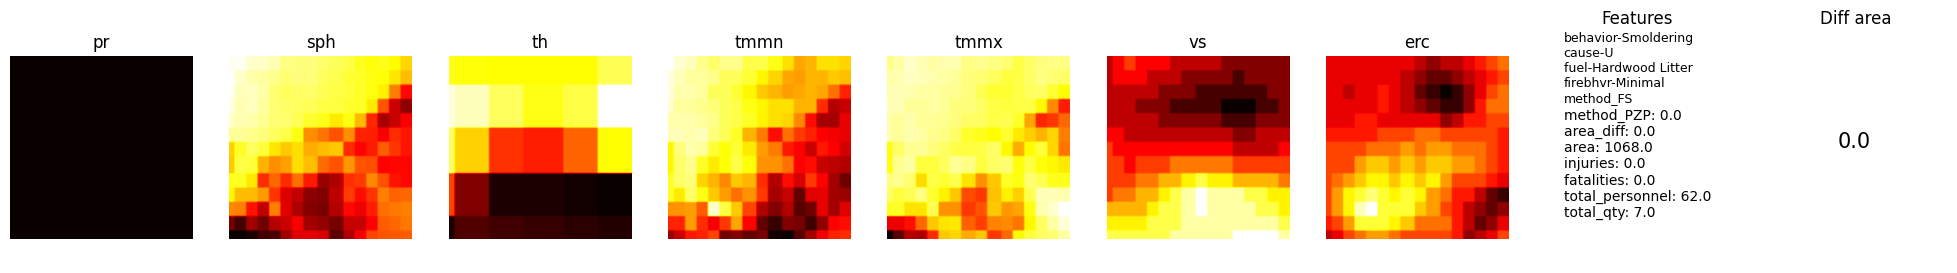

Report index: 2400, fire id: 2015_2846612_SADDLE


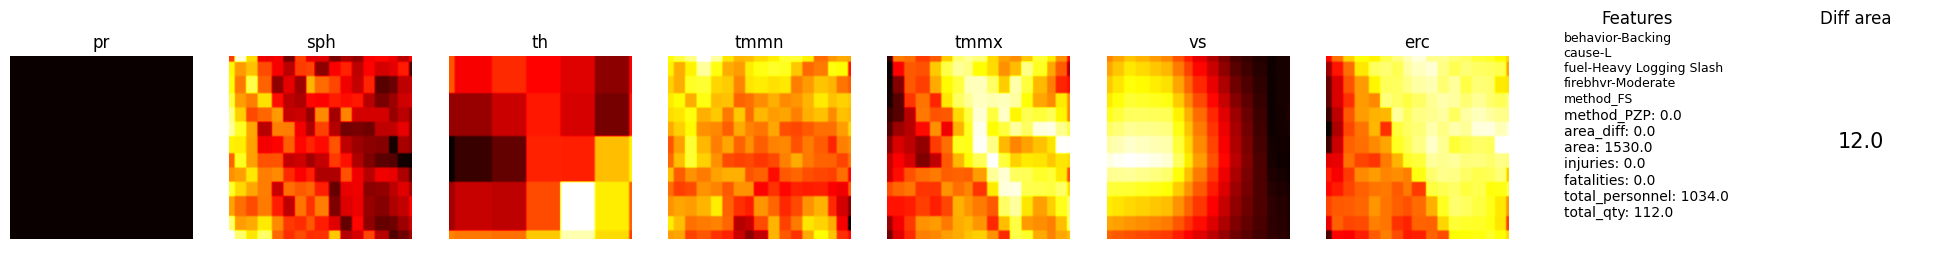

Report index: 463, fire id: 2015_2738172_SPRING


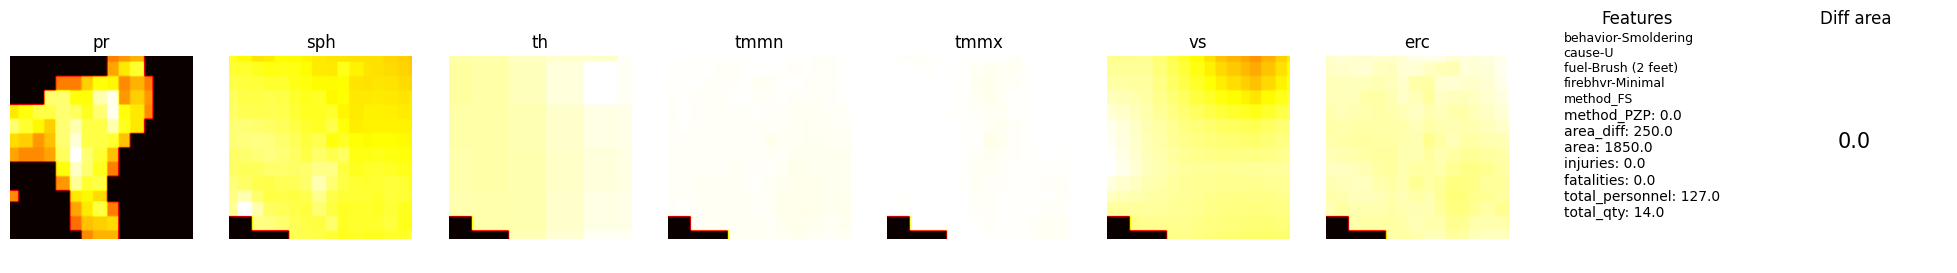

Report index: 23458, fire id: 2018_9253058_OBI


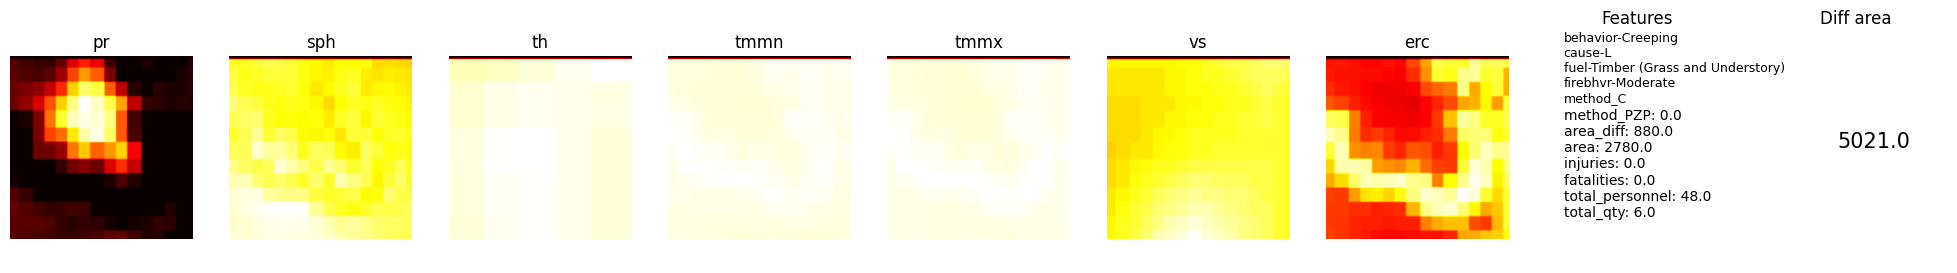

Report index: 5474, fire id: 2016_4260724_PONY


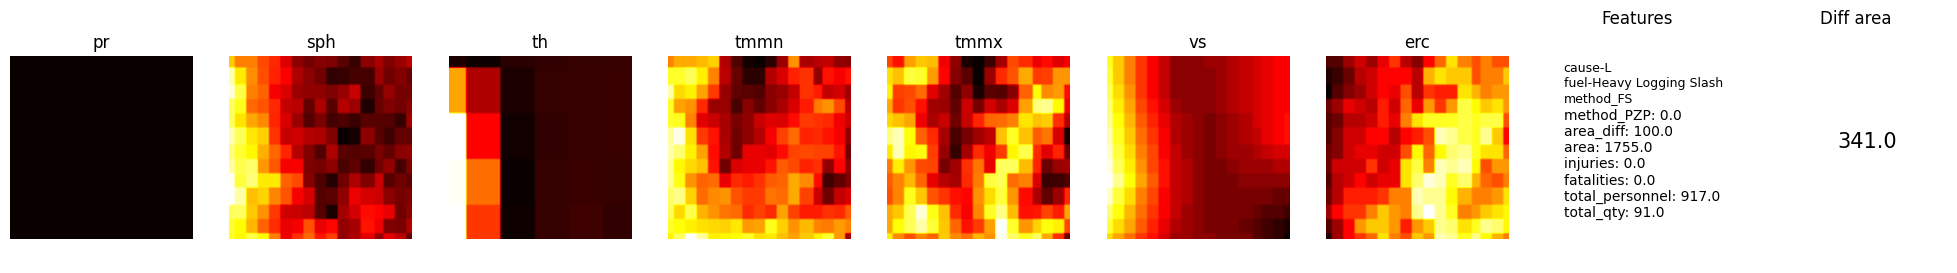

Report index: 18705, fire id: 2018_9040937_MURDOCK


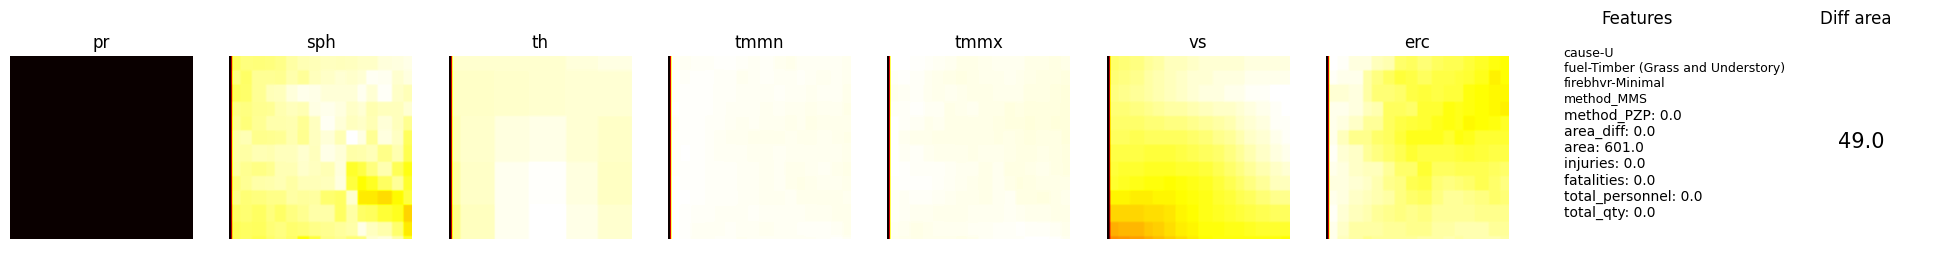

Report index: 21079, fire id: 2018_9148736_COVE CREEK


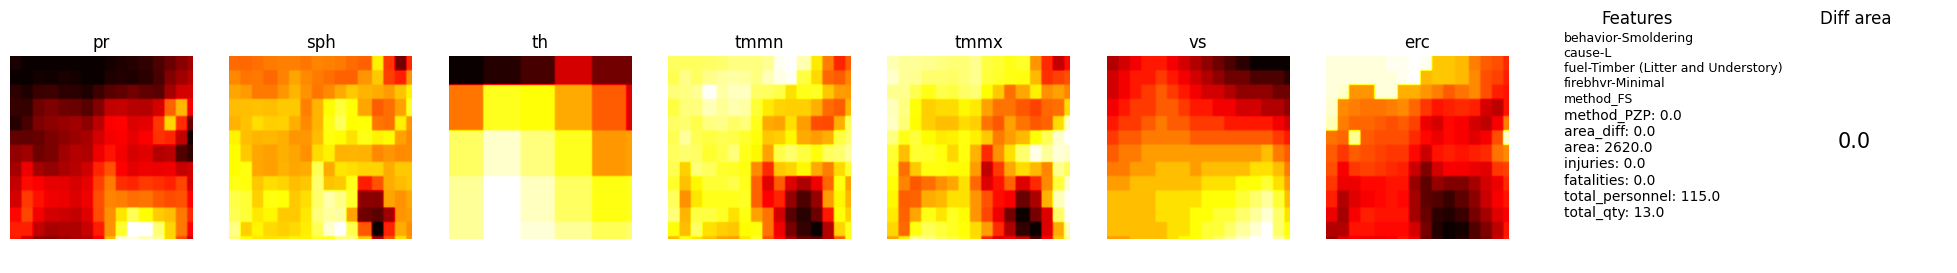

Report index: 1899, fire id: 2015_2822824_TUU LIGHTNING COMPLEX


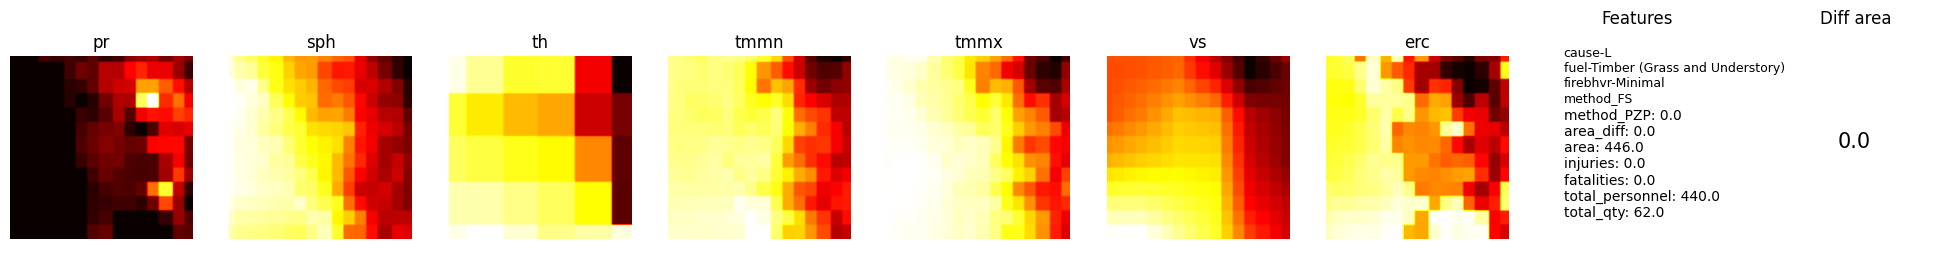

Report index: 12503, fire id: 2017_7202473_STAR FIRE


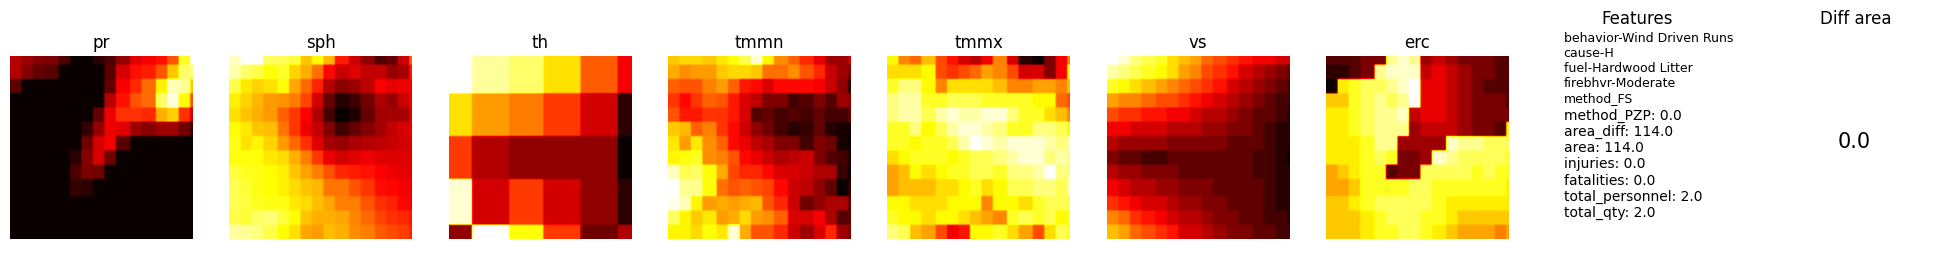

Report index: 1709, fire id: 2015_2810809_LAKE


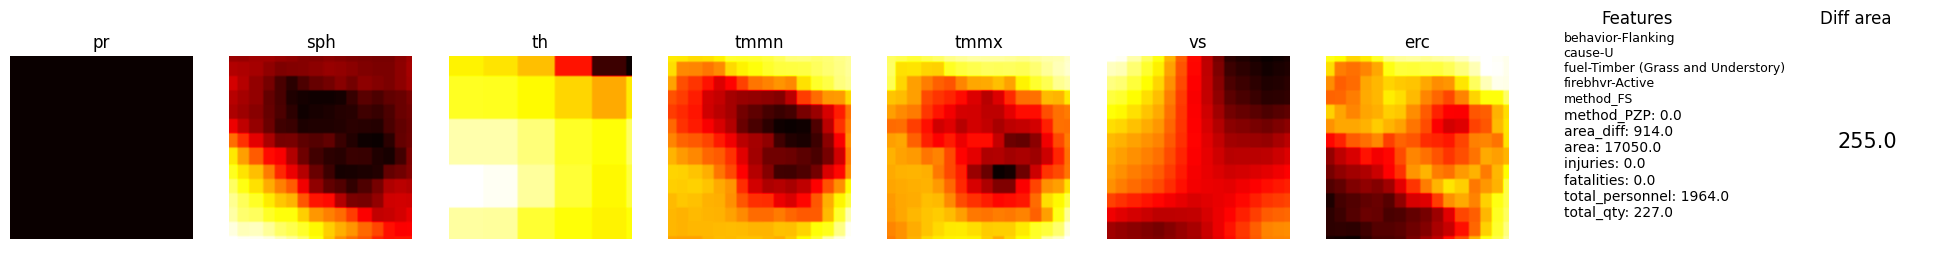

Report index: 1584, fire id: 2015_2803297_BUNKER HILL COMPLEX


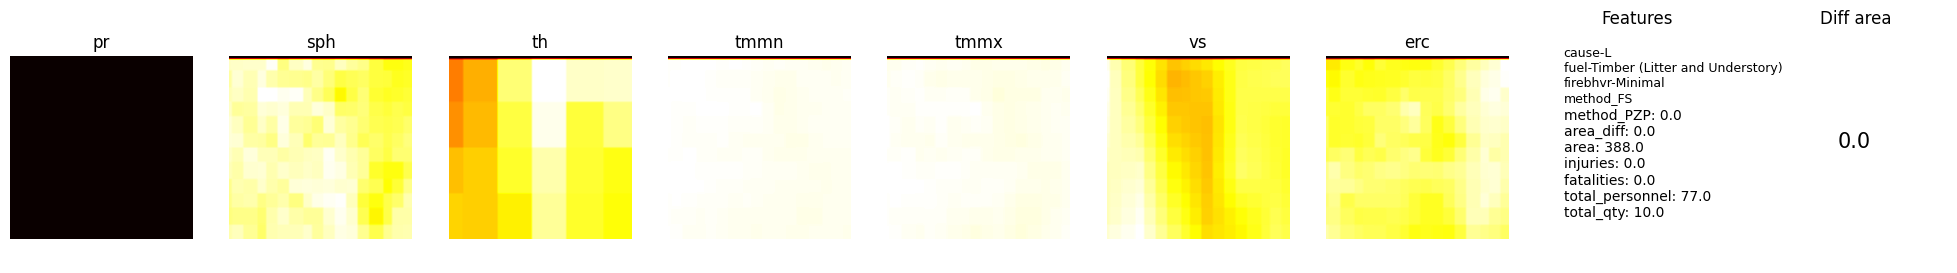

Report index: 18554, fire id: 2018_9035697_CLEAR LAKE


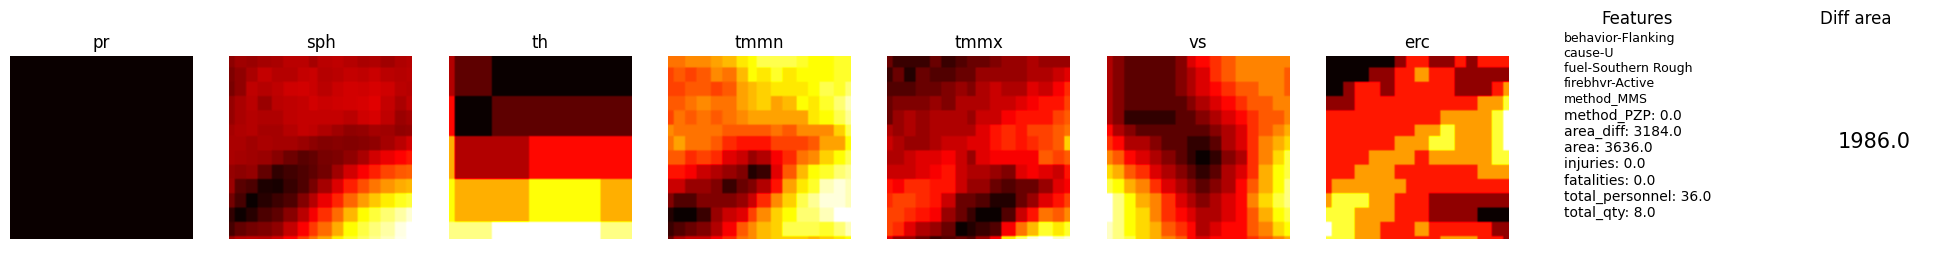

Report index: 13797, fire id: 2017_7261897_SUTHERLAND CANYON


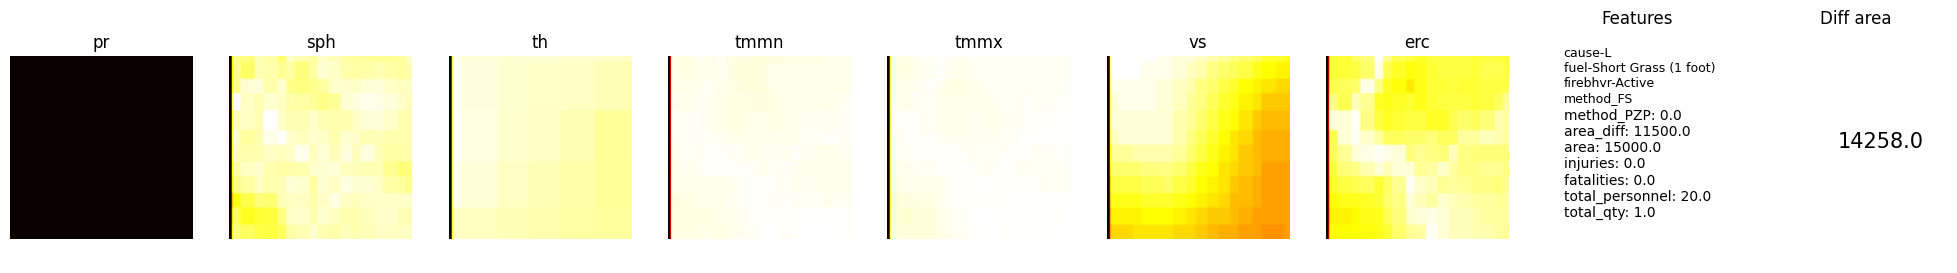

Report index: 16148, fire id: 2017_7352900_CAJETE


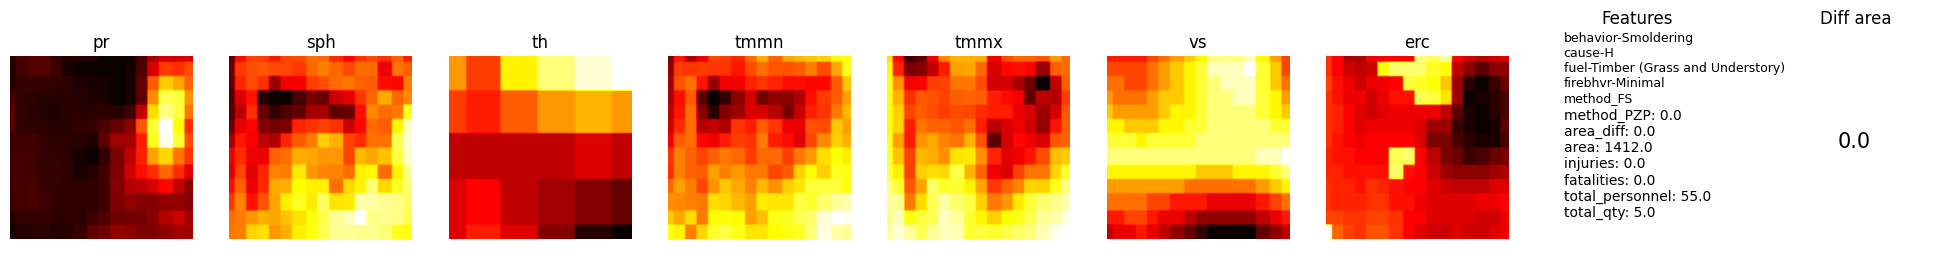

Report index: 7996, fire id: 2016_4370386_RELAY


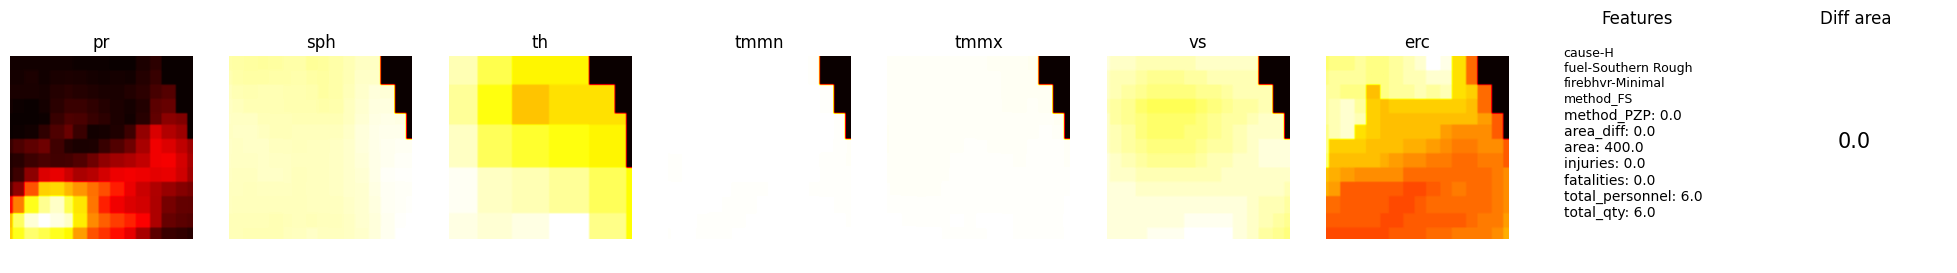

Report index: 23839, fire id: 2018_9271045_CHARLIE


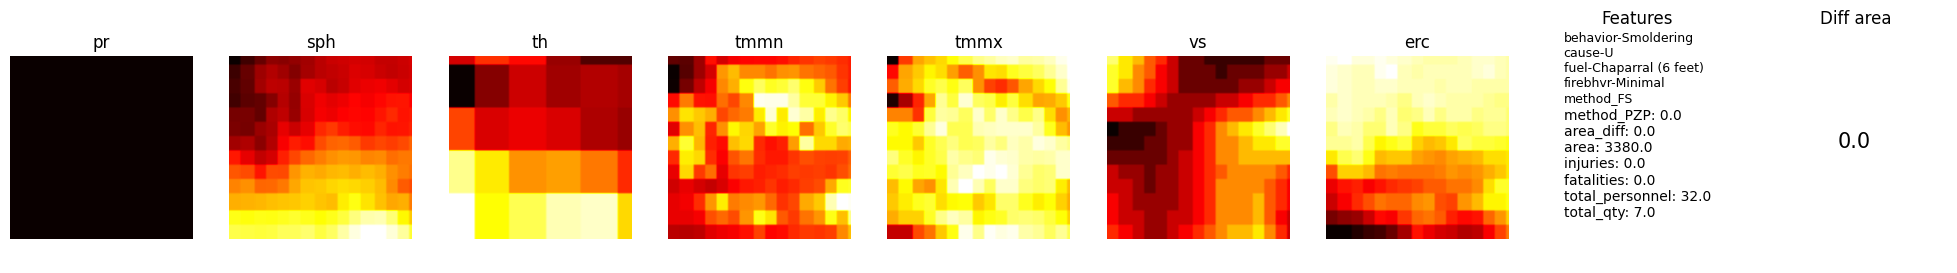

Report index: 19886, fire id: 2018_9095328_SMITH CREEK


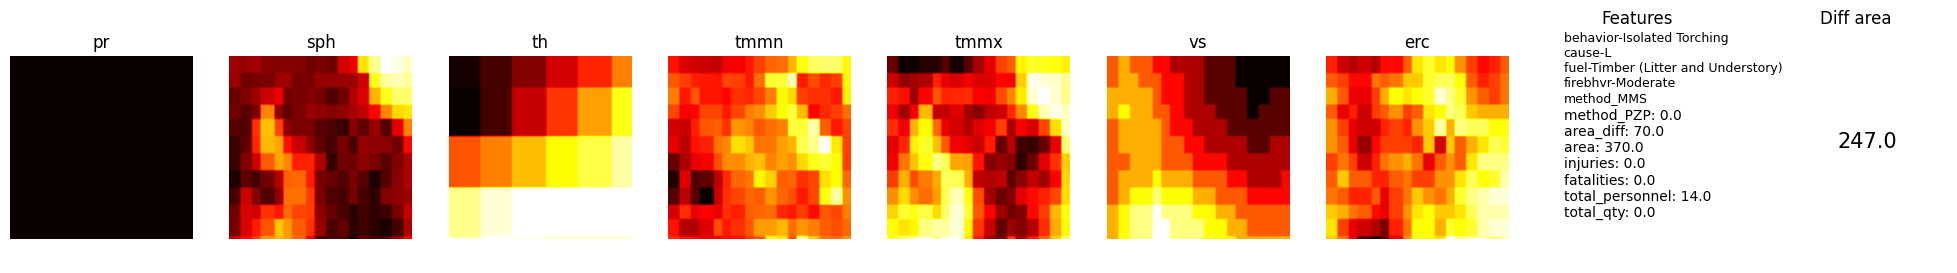

Report index: 9341, fire id: 2016_4410152_FULTON


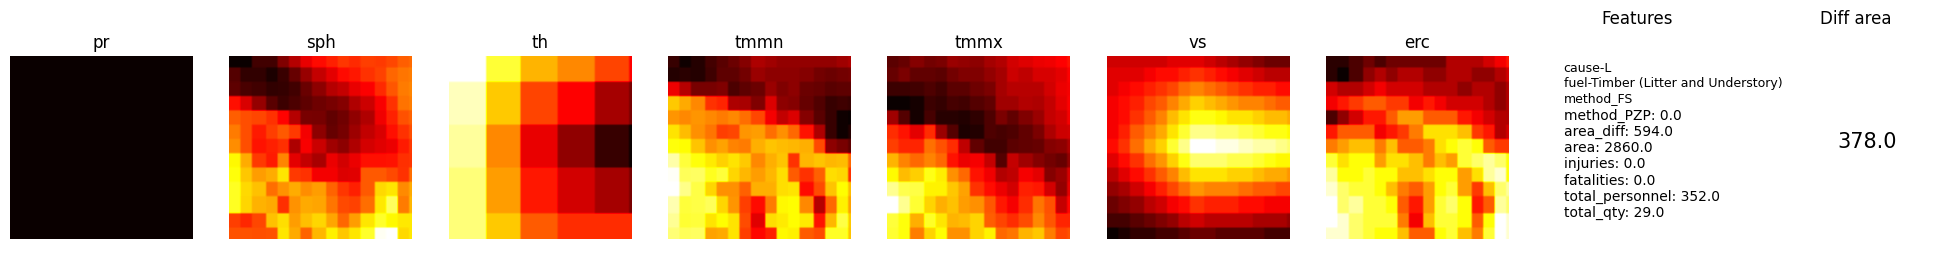

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_dataset_item(dataset, layer_names, feature_names, idx):
    features, images_tensor, target = dataset[idx]

    images_np = images_tensor.numpy()

    fig, axs = plt.subplots(1, 9, figsize=(25, 3))  # 7 for the images, 1 for the features

    # images
    for i in range(images_np.shape[0]):
        axs[i].imshow(images_np[i], cmap=plt.get_cmap('hot'))
        axs[i].set_title(layer_names[i])
        axs[i].axis('off')

    # one hot features
    active_features = [feat for i, feat in enumerate(feature_names[:-7]) if features[i]>0.1]

    axs[7].text(0.1, 0.7, "\n".join(active_features), fontsize=9)
    axs[7].text(0.1, 0.2, "\n".join([f"{feature_names[-7+i]}: {features[-7+i]}" for i in range(7)]))
    axs[7].axis('off')
    axs[7].set_title('Features')

    axs[8].text(0.4, 0.5, target.item(), fontsize=15)
    axs[8].axis('off')
    axs[8].set_title('Diff area')
    plt.show()

layers = ['pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs', 'erc']

for i in range(20):
  idx = np.random.randint(0, len(dataset))
  print(f"Report index: {idx}, fire id: {dataset.dataframe.iloc[idx].loc['id']}")
  visualize_dataset_item(dataset, layers, features, idx)

## Prediction

## Multimodal

In [ ]:
import torch.nn as nn
from torchvision import models

class EfficientNetB0_FireDataset(nn.Module):
    def __init__(self, num_features):
        super(EfficientNetB0_FireDataset, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        original_conv = self.efficientnet.features[0][0]

        # 7 channels
        self.efficientnet.features[0][0] = nn.Conv2d(
                                                      7,
                                                      original_conv.out_channels,
                                                      kernel_size=original_conv.kernel_size,
                                                      stride=original_conv.stride,
                                                      padding=original_conv.padding,
                                                      bias=original_conv.bias
                                                     )

        for param in self.efficientnet.features[-1].parameters():
            param.requires_grad = True


        for param in self.efficientnet.parameters():
            param.requires_grad = False


        num_ftrs = self.efficientnet.classifier[1].in_features

        self.efficientnet.classifier = nn.Linear(num_ftrs, 128)
        for param in self.efficientnet.classifier.parameters():
          param.requires_grad = True

        self.tab_features = nn.Sequential(
            nn.Linear(48, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU()
        )
        self.final_layer = nn.Linear(128 + 4, 1)

        for param in self.final_layer.parameters():
          param.requires_grad = True

    def forward(self, images, features):
        x1 = self.efficientnet(images)
        x2 = self.tab_features(features)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layer(x)
        return x
super_features_2 = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetB0_FireDataset(num_features=dataset).to(device)

### Remove bad indices
* if area = 0
* if images = 0 ??? NONE?? i removed them before then..

In [ ]:
from torch.utils.data import DataLoader, Subset
dataset = torch.load("/content/drive/My Drive/RA/cleaned_dataset.pt")
df = dataset.dataframe
nice_indices = df[(df['area']!=0)&(df['next_area_diff']!=0)].index
len(Subset(dataset, nice_indices))
dataset = Subset(dataset, nice_indices)

In [ ]:
len(dataset)*0.8

6599.200000000001

In [ ]:
from torch.utils.data import DataLoader, Subset
cut_idx = 6593 # for area != 0 + next_area_diff!=0 # 19021 # for area!0
batch_size = 16
train_loader = DataLoader(Subset(dataset, range(cut_idx)), batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(Subset(dataset, range(cut_idx, len(dataset))), batch_size=batch_size,  num_workers=4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
n_train = len(train_loader)*batch_size
n_eval = len(val_loader)*batch_size

In [ ]:
from tqdm import tqdm
num_epochs = 100

super_images = None
super_features = None
train_losses = []
eval_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for features, images, targets in train_loader:
        features, images, targets = features.to(device), images.to(device), targets.to(device)
        optimizer.zero_grad()
        super_images = images
        super_features = features
        outputs = model.forward(images, features)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss)
    print(f'\nEpoch {epoch+1}, Traing loss: {running_loss/len(train_loader)}')

    model.eval()
    eval_loss = 0.0
    for features, images, targets in val_loader:
        with torch.no_grad():
          images, features, targets = images.to(device), features.to(device), targets.to(device)
          outputs = model(images, features)
          loss = criterion(outputs, targets.unsqueeze(1))
          eval_loss += loss.item()
    print(f'\nValidation loss: {eval_loss/len(val_loader)}')
    eval_losses.append(eval_loss)

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1, Traing loss: 39209175.05814921


  1%|          | 1/100 [00:19<32:34, 19.74s/it]


Validation loss: 149437168.0

Epoch 2, Traing loss: 38606731.56900726


  2%|▏         | 2/100 [00:38<31:20, 19.19s/it]


Validation loss: 145619664.0

Epoch 3, Traing loss: 37246919.78639528


  3%|▎         | 3/100 [00:57<30:49, 19.07s/it]


Validation loss: 143948512.0

Epoch 4, Traing loss: 36811351.89486229


  4%|▍         | 4/100 [01:16<30:46, 19.23s/it]


Validation loss: 142918240.0

Epoch 5, Traing loss: 37151032.35873184


  5%|▌         | 5/100 [01:35<29:53, 18.88s/it]


Validation loss: 153326336.0

Epoch 6, Traing loss: 36724540.31696428


  6%|▌         | 6/100 [01:53<29:19, 18.72s/it]


Validation loss: 143287040.0

Epoch 7, Traing loss: 36376466.85032347


  7%|▋         | 7/100 [02:12<29:17, 18.89s/it]


Validation loss: 506161024.0

Epoch 8, Traing loss: 37178510.89232748


  8%|▊         | 8/100 [02:31<28:40, 18.70s/it]


Validation loss: 171387504.0

Epoch 9, Traing loss: 36756956.007717915


  9%|▉         | 9/100 [02:49<28:10, 18.58s/it]


Validation loss: 223452832.0

Epoch 10, Traing loss: 36581987.20815678


 10%|█         | 10/100 [03:09<28:19, 18.89s/it]


Validation loss: 191920128.0

Epoch 11, Traing loss: 36675675.68886199


 11%|█         | 11/100 [03:29<28:32, 19.24s/it]


Validation loss: 144268736.0

Epoch 12, Traing loss: 36619877.82086108


 12%|█▏        | 12/100 [03:47<27:46, 18.94s/it]


Validation loss: 189745472.0

Epoch 13, Traing loss: 36630469.750302665


 13%|█▎        | 13/100 [04:06<27:41, 19.10s/it]


Validation loss: 279479008.0

Epoch 14, Traing loss: 36691723.97798123


 14%|█▍        | 14/100 [04:25<27:05, 18.91s/it]


Validation loss: 147837856.0

Epoch 15, Traing loss: 36428251.310050316


 15%|█▌        | 15/100 [04:43<26:36, 18.78s/it]


Validation loss: 142424288.0

Epoch 16, Traing loss: 36472047.92308565


 16%|█▌        | 16/100 [05:03<26:34, 18.99s/it]


Validation loss: 144854576.0

Epoch 17, Traing loss: 36742515.92143992


 17%|█▋        | 17/100 [05:21<25:57, 18.76s/it]


Validation loss: 171829248.0

Epoch 18, Traing loss: 36647322.18931598


 18%|█▊        | 18/100 [05:40<25:34, 18.72s/it]


Validation loss: 144817088.0

Epoch 19, Traing loss: 36642375.11949531


 19%|█▉        | 19/100 [05:58<25:18, 18.75s/it]


Validation loss: 166650576.0

Epoch 20, Traing loss: 36518801.22658142


 20%|██        | 20/100 [06:17<24:47, 18.59s/it]


Validation loss: 152420096.0

Epoch 21, Traing loss: 36543322.79131356


 21%|██        | 21/100 [06:36<24:45, 18.80s/it]


Validation loss: 145972192.0

Epoch 22, Traing loss: 36388791.31779661


 22%|██▏       | 22/100 [06:56<24:49, 19.10s/it]


Validation loss: 144745568.0

Epoch 23, Traing loss: 36582349.16778904


 23%|██▎       | 23/100 [07:14<24:15, 18.91s/it]


Validation loss: 145207152.0

Epoch 24, Traing loss: 36152137.457854114


 24%|██▍       | 24/100 [07:34<24:12, 19.11s/it]


Validation loss: 147879456.0

Epoch 25, Traing loss: 36376975.50121065


 25%|██▌       | 25/100 [07:52<23:39, 18.93s/it]


Validation loss: 146875360.0

Epoch 26, Traing loss: 36779420.6340799


 26%|██▌       | 26/100 [08:11<23:12, 18.81s/it]


Validation loss: 158906992.0

Epoch 27, Traing loss: 36274892.35895884


 27%|██▋       | 27/100 [08:30<22:59, 18.90s/it]


Validation loss: 143550096.0

Epoch 28, Traing loss: 36270129.75847457


 28%|██▊       | 28/100 [08:48<22:31, 18.77s/it]


Validation loss: 240088992.0

Epoch 29, Traing loss: 36273792.219884984


 29%|██▉       | 29/100 [09:08<22:24, 18.93s/it]


Validation loss: 145306880.0

Epoch 30, Traing loss: 36325358.15118039


 30%|███       | 30/100 [09:26<21:59, 18.86s/it]


Validation loss: 184506704.0

Epoch 31, Traing loss: 36728461.72608959


 31%|███       | 31/100 [09:45<21:30, 18.70s/it]


Validation loss: 146343056.0

Epoch 32, Traing loss: 36452732.832778454


 32%|███▏      | 32/100 [10:05<21:34, 19.03s/it]


Validation loss: 266351072.0

Epoch 33, Traing loss: 36089232.99341707


 33%|███▎      | 33/100 [10:23<21:04, 18.88s/it]


Validation loss: 160114816.0

Epoch 34, Traing loss: 36431731.850734904


 34%|███▍      | 34/100 [10:41<20:37, 18.76s/it]


Validation loss: 142260304.0

Epoch 35, Traing loss: 36242107.595811896


 35%|███▌      | 35/100 [11:03<21:05, 19.47s/it]


Validation loss: 148725776.0

Epoch 36, Traing loss: 36312542.70081719


 36%|███▌      | 36/100 [11:21<20:26, 19.16s/it]


Validation loss: 142110560.0

Epoch 37, Traing loss: 36177940.27595812


 37%|███▋      | 37/100 [11:40<20:08, 19.19s/it]


Validation loss: 149911632.0

Epoch 38, Traing loss: 36179044.74319953


 38%|███▊      | 38/100 [11:59<19:42, 19.07s/it]


Validation loss: 142218352.0

Epoch 39, Traing loss: 35945963.2311592


 39%|███▉      | 39/100 [12:17<19:06, 18.80s/it]


Validation loss: 144675840.0

Epoch 40, Traing loss: 35896486.93000908


 40%|████      | 40/100 [12:37<19:03, 19.07s/it]


Validation loss: 149085872.0

Epoch 41, Traing loss: 35882388.50550942


 41%|████      | 41/100 [12:56<18:38, 18.96s/it]


Validation loss: 166655616.0

Epoch 42, Traing loss: 35819379.657990314


 42%|████▏     | 42/100 [13:14<18:12, 18.83s/it]


Validation loss: 145952144.0

Epoch 43, Traing loss: 36556095.40288287


 43%|████▎     | 43/100 [13:34<18:02, 18.98s/it]


Validation loss: 144657776.0

Epoch 44, Traing loss: 36063643.32046028


 44%|████▍     | 44/100 [13:52<17:29, 18.74s/it]


Validation loss: 142783296.0

Epoch 45, Traing loss: 36255364.89898608


 45%|████▌     | 45/100 [14:12<17:29, 19.08s/it]


Validation loss: 146777040.0

Epoch 46, Traing loss: 35849865.60631053


 46%|████▌     | 46/100 [14:32<17:31, 19.47s/it]


Validation loss: 142427440.0

Epoch 47, Traing loss: 35991009.056144066


 47%|████▋     | 47/100 [14:50<16:52, 19.10s/it]


Validation loss: 164757456.0

Epoch 48, Traing loss: 35553787.37991828


 48%|████▊     | 48/100 [15:09<16:27, 18.99s/it]


Validation loss: 167734912.0

Epoch 49, Traing loss: 36234587.10767252


 49%|████▉     | 49/100 [15:28<16:02, 18.88s/it]


Validation loss: 184856272.0

Epoch 50, Traing loss: 36262999.19135896


 50%|█████     | 50/100 [15:46<15:33, 18.67s/it]


Validation loss: 144271520.0

Epoch 51, Traing loss: 36059930.03293356


 51%|█████     | 51/100 [16:05<15:21, 18.81s/it]


Validation loss: 143071120.0

Epoch 52, Traing loss: 35988039.63530002


 52%|█████▏    | 52/100 [16:23<14:59, 18.74s/it]


Validation loss: 147760944.0

Epoch 53, Traing loss: 36140161.852962315


 53%|█████▎    | 53/100 [16:41<14:29, 18.50s/it]


Validation loss: 162304144.0

Epoch 54, Traing loss: 35452128.316415705


 54%|█████▍    | 54/100 [17:00<14:18, 18.67s/it]


Validation loss: 144569376.0

Epoch 55, Traing loss: 36017721.71027543


 55%|█████▌    | 55/100 [17:19<13:54, 18.55s/it]


Validation loss: 144030624.0

Epoch 56, Traing loss: 35702454.80743039


 56%|█████▌    | 56/100 [17:38<13:48, 18.82s/it]


Validation loss: 153724240.0

Epoch 57, Traing loss: 35781785.46292373


 57%|█████▋    | 57/100 [17:58<13:36, 18.99s/it]


Validation loss: 142428240.0

Epoch 58, Traing loss: 35847968.278374694


 58%|█████▊    | 58/100 [18:15<13:03, 18.65s/it]


Validation loss: 152597088.0

Epoch 59, Traing loss: 35551827.97669491


 59%|█████▉    | 59/100 [18:33<12:37, 18.47s/it]


Validation loss: 142347312.0

Epoch 60, Traing loss: 35543449.91812954


 60%|██████    | 60/100 [18:53<12:26, 18.66s/it]


Validation loss: 148358608.0

Epoch 61, Traing loss: 36803023.71996065


 61%|██████    | 61/100 [19:11<11:59, 18.45s/it]


Validation loss: 142329920.0

Epoch 62, Traing loss: 36597565.16812954


 62%|██████▏   | 62/100 [19:28<11:34, 18.29s/it]


Validation loss: 148338544.0

Epoch 63, Traing loss: 36005941.25136199


 63%|██████▎   | 63/100 [19:48<11:25, 18.53s/it]


Validation loss: 147838160.0

Epoch 64, Traing loss: 36204619.80115012


 64%|██████▍   | 64/100 [20:06<11:01, 18.36s/it]


Validation loss: 148888448.0

Epoch 65, Traing loss: 35753153.52406175


 65%|██████▌   | 65/100 [20:23<10:37, 18.23s/it]


Validation loss: 159252208.0

Epoch 66, Traing loss: 35591936.98418584


 66%|██████▌   | 66/100 [20:43<10:30, 18.55s/it]


Validation loss: 141922512.0

Epoch 67, Traing loss: 36041778.1779661


 67%|██████▋   | 67/100 [21:02<10:20, 18.80s/it]


Validation loss: 144726992.0

Epoch 68, Traing loss: 35441641.19824455


 68%|██████▊   | 68/100 [21:20<09:53, 18.54s/it]


Validation loss: 142589072.0

Epoch 69, Traing loss: 36022990.35381356


 69%|██████▉   | 69/100 [21:39<09:37, 18.64s/it]


Validation loss: 160680608.0

Epoch 70, Traing loss: 36065911.09670097


 70%|███████   | 70/100 [21:57<09:11, 18.39s/it]


Validation loss: 146474352.0

Epoch 71, Traing loss: 36396799.32702784


 71%|███████   | 71/100 [22:15<08:51, 18.32s/it]


Validation loss: 142593856.0

Epoch 72, Traing loss: 35451632.30387409


 72%|███████▏  | 72/100 [22:34<08:36, 18.45s/it]


Validation loss: 143041360.0

Epoch 73, Traing loss: 35285403.26195521


 73%|███████▎  | 73/100 [22:51<08:11, 18.20s/it]


Validation loss: 144965200.0

Epoch 74, Traing loss: 35961699.43311138


 74%|███████▍  | 74/100 [23:09<07:51, 18.12s/it]


Validation loss: 145073808.0

Epoch 75, Traing loss: 35338742.01944613


 75%|███████▌  | 75/100 [23:28<07:35, 18.21s/it]


Validation loss: 143588256.0

Epoch 76, Traing loss: 35621657.93717842


 76%|███████▌  | 76/100 [23:45<07:13, 18.06s/it]


Validation loss: 142159056.0

Epoch 77, Traing loss: 35579880.13294491


 77%|███████▋  | 77/100 [24:04<06:56, 18.13s/it]


Validation loss: 144885040.0

Epoch 78, Traing loss: 35134069.71436138


 78%|███████▊  | 78/100 [24:22<06:42, 18.31s/it]


Validation loss: 143076800.0

Epoch 79, Traing loss: 35482228.95293584


 79%|███████▉  | 79/100 [24:41<06:29, 18.57s/it]


Validation loss: 150975792.0

Epoch 80, Traing loss: 35098236.37106538


 80%|████████  | 80/100 [25:01<06:17, 18.85s/it]


Validation loss: 217223760.0

Epoch 81, Traing loss: 35460088.731083535


 81%|████████  | 81/100 [25:20<05:58, 18.87s/it]


Validation loss: 171721296.0

Epoch 82, Traing loss: 35470380.2161017


 82%|████████▏ | 82/100 [25:38<05:36, 18.67s/it]


Validation loss: 164290432.0

Epoch 83, Traing loss: 34812643.90892668


 83%|████████▎ | 83/100 [25:57<05:20, 18.84s/it]


Validation loss: 163943888.0

Epoch 84, Traing loss: 35630578.02614123


 84%|████████▍ | 84/100 [26:15<04:57, 18.57s/it]


Validation loss: 181863968.0

Epoch 85, Traing loss: 35192315.25741526


 85%|████████▌ | 85/100 [26:33<04:35, 18.39s/it]


Validation loss: 160457552.0

Epoch 86, Traing loss: 35312758.74016344


 86%|████████▌ | 86/100 [26:52<04:20, 18.59s/it]


Validation loss: 147011072.0

Epoch 87, Traing loss: 34772163.64512712


 87%|████████▋ | 87/100 [27:10<03:58, 18.38s/it]


Validation loss: 160605984.0

Epoch 88, Traing loss: 34918537.46216707


 88%|████████▊ | 88/100 [27:28<03:38, 18.21s/it]


Validation loss: 214351344.0

Epoch 89, Traing loss: 35368683.58292978


 89%|████████▉ | 89/100 [27:48<03:24, 18.60s/it]


Validation loss: 143377632.0

Epoch 90, Traing loss: 35076107.00068099


 90%|█████████ | 90/100 [28:07<03:07, 18.71s/it]


Validation loss: 142683984.0

Epoch 91, Traing loss: 35010074.26256053


 91%|█████████ | 91/100 [28:24<02:45, 18.39s/it]


Validation loss: 148330080.0

Epoch 92, Traing loss: 35426258.50039724


 92%|█████████▏| 92/100 [28:43<02:28, 18.60s/it]


Validation loss: 148764800.0

Epoch 93, Traing loss: 34958015.1655569


 93%|█████████▎| 93/100 [29:01<02:08, 18.36s/it]


Validation loss: 146593216.0

Epoch 94, Traing loss: 35062312.531448625


 94%|█████████▍| 94/100 [29:19<01:49, 18.25s/it]


Validation loss: 151352992.0

Epoch 95, Traing loss: 35610983.23774213


 95%|█████████▌| 95/100 [29:38<01:32, 18.54s/it]


Validation loss: 146721056.0

Epoch 96, Traing loss: 35120471.395278454


 96%|█████████▌| 96/100 [29:56<01:13, 18.35s/it]


Validation loss: 143306208.0

Epoch 97, Traing loss: 34467062.692257494


 97%|█████████▋| 97/100 [30:15<00:55, 18.36s/it]


Validation loss: 141421264.0

Epoch 98, Traing loss: 35667700.86243947


 98%|█████████▊| 98/100 [30:33<00:36, 18.46s/it]


Validation loss: 148964688.0

Epoch 99, Traing loss: 35250365.69272094


 99%|█████████▉| 99/100 [30:51<00:18, 18.28s/it]


Validation loss: 143637760.0

Epoch 100, Traing loss: 34568815.928571425


100%|██████████| 100/100 [31:10<00:00, 18.71s/it]


Validation loss: 145295632.0


In [ ]:
eval_losses = [ev.item() for ev in eval_losses]

In [ ]:
train_losses = [t/n_train for t in train_losses]
eval_losses = [ev/n_eval for ev in eval_losses]

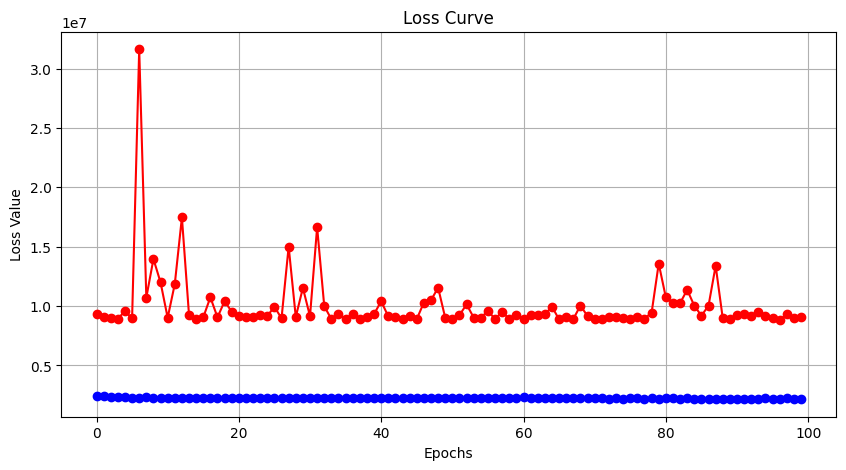

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o', linestyle='-', color='b')
plt.plot(eval_losses, marker='o', linestyle="-", color="r")
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()